### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import copy
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Definitions of classes

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e4) # Adjust the magnitude if needed
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [3]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

### Encoder

In [112]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

### Decoder

In [113]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

### Transformer

In [114]:
class TransformerClassifier(nn.Module):
    def __init__(self, src_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, num_classes):
        super(TransformerClassifier, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes) # Final layer for classification
        

    def generate_mask(self, src):
        src_mask = (src != input_vocabulary["<pad>"]).unsqueeze(1).unsqueeze(2)
        return src_mask

    def forward(self, src):
        src_mask = self.generate_mask(src)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = checkpoint.checkpoint(enc_layer, enc_output, src_mask, use_reentrant=False) # Wrapped in checkpoint for memory efficiency

        # Pool the encoder output (e.g. take the mean over the sequence length)
        enc_output = enc_output.mean(dim=1) # Shape: (batch_size, d_model)
        output = self.fc(enc_output) # Shape: (batch_size, num_classes)
        return output

### Data preparation

In [115]:
# Define hyperparameters (adjust as needed)
d_model = 128 # Originally was 512
num_heads = 2 # 8
num_layers = 2 # 6
d_ff = 256 # 2048
max_seq_length = 16 # 128  # Adjust based on your data
dropout = 0.1
batch_size = 4 # 64 made my GPU run out of memory, but you can try it! ;)
num_epochs = 1 # 10

In [11]:
ds=load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")

train_set=pd.DataFrame(ds["train"])
test_set=pd.DataFrame(ds["validation"])
print(train_set)
y_train = train_set["label"].tolist()
X_train = train_set.pop("label").tolist()

y_test = test_set["label"].tolist()
X_test = test_set.pop("label").tolist()

Using the latest cached version of the dataset since sapienzanlp/nlp2025_hw1_cultural_dataset couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/emilioleo/.cache/huggingface/datasets/sapienzanlp___nlp2025_hw1_cultural_dataset/default/0.0.0/9952968991d009a4133cffd8164720c5d4d541db (last modified on Mon Apr 14 15:20:25 2025).


                                         item                 name  \
0       http://www.wikidata.org/entity/Q32786                  916   
1         http://www.wikidata.org/entity/Q371                  !!!   
2     http://www.wikidata.org/entity/Q3729947            ¡Soborno!   
3      http://www.wikidata.org/entity/Q158611                  +44   
4      http://www.wikidata.org/entity/Q280375        1 Monk Street   
...                                       ...                  ...   
6246   http://www.wikidata.org/entity/Q248878                 Zust   
6247  http://www.wikidata.org/entity/Q1972616            zvonnitsa   
6248    http://www.wikidata.org/entity/Q10779              Zwenkau   
6249   http://www.wikidata.org/entity/Q245296               zydeco   
6250   http://www.wikidata.org/entity/Q129298  Zygmunt Chmielewski   

                                            description     type  \
0                               2012 film by M. Mohanan   entity   
1              American

In [9]:
# 1. Tokenization and vocabulary creation

def tokenize(text):
    return text.lower().split()  # Simple word tokenization, can be improved

train_tokens_inputs = [tokenize(text) for text in X_train]
print(train_tokens_inputs)
test_tokens_inputs = [tokenize(text) for text in X_test]
train_tokens_labels = [tokenize(label) for label in y_train]
test_tokens_labels = [tokenize(label) for label in y_test]

def build_vocabulary(token_list, min_freq=1):
    token_counts = Counter(token for sublist in token_list for token in sublist)
    # Sort tokens by frequency and then alphabetically
    sorted_tokens = sorted(token_counts.items(), key=lambda item: (item[1], item[0]), reverse=True)
    vocabulary = {
        "<pad>": 0,
        "<unk>": 1,
        "<sos>": 2,
        "<eos>": 3
    }
    index = len(vocabulary)
    for token, count in sorted_tokens:
        if count >= min_freq and token not in vocabulary:
            vocabulary[token] = index
            index += 1
    return vocabulary

input_vocabulary = build_vocabulary(train_tokens_inputs + test_tokens_inputs)
output_vocabulary = build_vocabulary(train_tokens_labels + test_tokens_labels)
print(input_vocabulary)
src_vocab_size = len(input_vocabulary)
tgt_vocab_size = len(output_vocabulary)

input_index_to_token = {idx: token for token, idx in input_vocabulary.items()}
output_index_to_token = {idx: token for token, idx in output_vocabulary.items()}

[['cultural', 'exclusive'], ['cultural', 'representative'], ['cultural', 'representative'], ['cultural', 'representative'], ['cultural', 'exclusive'], ['cultural', 'agnostic'], ['cultural', 'agnostic'], ['cultural', 'agnostic'], ['cultural', 'exclusive'], ['cultural', 'representative'], ['cultural', 'representative'], ['cultural', 'representative'], ['cultural', 'representative'], ['cultural', 'representative'], ['cultural', 'exclusive'], ['cultural', 'agnostic'], ['cultural', 'agnostic'], ['cultural', 'agnostic'], ['cultural', 'agnostic'], ['cultural', 'agnostic'], ['cultural', 'agnostic'], ['cultural', 'exclusive'], ['cultural', 'exclusive'], ['cultural', 'representative'], ['cultural', 'exclusive'], ['cultural', 'exclusive'], ['cultural', 'representative'], ['cultural', 'representative'], ['cultural', 'representative'], ['cultural', 'representative'], ['cultural', 'representative'], ['cultural', 'representative'], ['cultural', 'exclusive'], ['cultural', 'exclusive'], ['cultural', 'r

In [118]:
# 2. Numericalization and Padding

def numericalize(tokens, vocabulary, max_len):
    numericalized = [vocabulary.get(token, vocabulary["<unk>"]) for token in tokens]
    numericalized = [vocabulary["<sos>"]] + numericalized + [vocabulary["<eos>"]]
    if len(numericalized) > max_len:
        numericalized = numericalized[:max_len]
    padding_length = max_len - len(numericalized)
    return numericalized + [vocabulary["<pad>"]] * padding_length

class ClassificationDataset(Dataset):
    def __init__(self, inputs, targets, input_vocab, max_len):
        self.inputs = [numericalize(tokenize(text), input_vocab, max_len) for text in inputs]
        self.targets = torch.tensor(targets, dtype=torch.long) # Store numerical labels
        self.max_len = max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), self.targets[idx]

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_) # Should be 3

train_dataset = ClassificationDataset(X_train, y_train_encoded, input_vocabulary, max_seq_length)
test_dataset = ClassificationDataset(X_test, y_test_encoded, input_vocabulary, max_seq_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=False)

### Training Phase

In [119]:
# Check for the gpu availability
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")

# Initialize the model
transformer = TransformerClassifier(src_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, num_classes).to(device)

In [120]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (src,tgt) in enumerate(train_dataloader):
        src = src.to(device)
        tgt = tgt.to(device)

        optimizer.zero_grad()
        output = transformer(src) # Get classification logits

        # The output shape will be (batch_size, num_classes)
        
        loss = criterion(output, tgt)
        loss.backward()
        
        optimizer.step()
        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

Epoch [1/1], Batch [0/1563], Loss: 1.2079
Epoch [1/1], Batch [100/1563], Loss: 0.0223
Epoch [1/1], Batch [100/1563], Loss: 0.0223
Epoch [1/1], Batch [200/1563], Loss: 0.0051
Epoch [1/1], Batch [200/1563], Loss: 0.0051
Epoch [1/1], Batch [300/1563], Loss: 0.0019
Epoch [1/1], Batch [300/1563], Loss: 0.0019
Epoch [1/1], Batch [400/1563], Loss: 0.0009
Epoch [1/1], Batch [400/1563], Loss: 0.0009
Epoch [1/1], Batch [500/1563], Loss: 0.0004
Epoch [1/1], Batch [500/1563], Loss: 0.0004
Epoch [1/1], Batch [600/1563], Loss: 0.0002
Epoch [1/1], Batch [600/1563], Loss: 0.0002
Epoch [1/1], Batch [700/1563], Loss: 0.0001
Epoch [1/1], Batch [700/1563], Loss: 0.0001
Epoch [1/1], Batch [800/1563], Loss: 0.0000
Epoch [1/1], Batch [800/1563], Loss: 0.0000
Epoch [1/1], Batch [900/1563], Loss: 0.0000
Epoch [1/1], Batch [900/1563], Loss: 0.0000
Epoch [1/1], Batch [1000/1563], Loss: 0.0000
Epoch [1/1], Batch [1000/1563], Loss: 0.0000
Epoch [1/1], Batch [1100/1563], Loss: 0.0000
Epoch [1/1], Batch [1100/1563],

### Evaluation

In [121]:
def predict_class(model, text, input_vocab, max_len, device):
    model.eval()
    tokens = tokenize(text)
    numericalized = numericalize(tokens, input_vocab, max_len)
    src_tensor = torch.LongTensor(numericalized).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(src_tensor)
        probabilities = torch.softmax(output, dim=1) # Get probabilities
        predicted_class_index = torch.argmax(probabilities, dim=1).item()
    return predicted_class_index

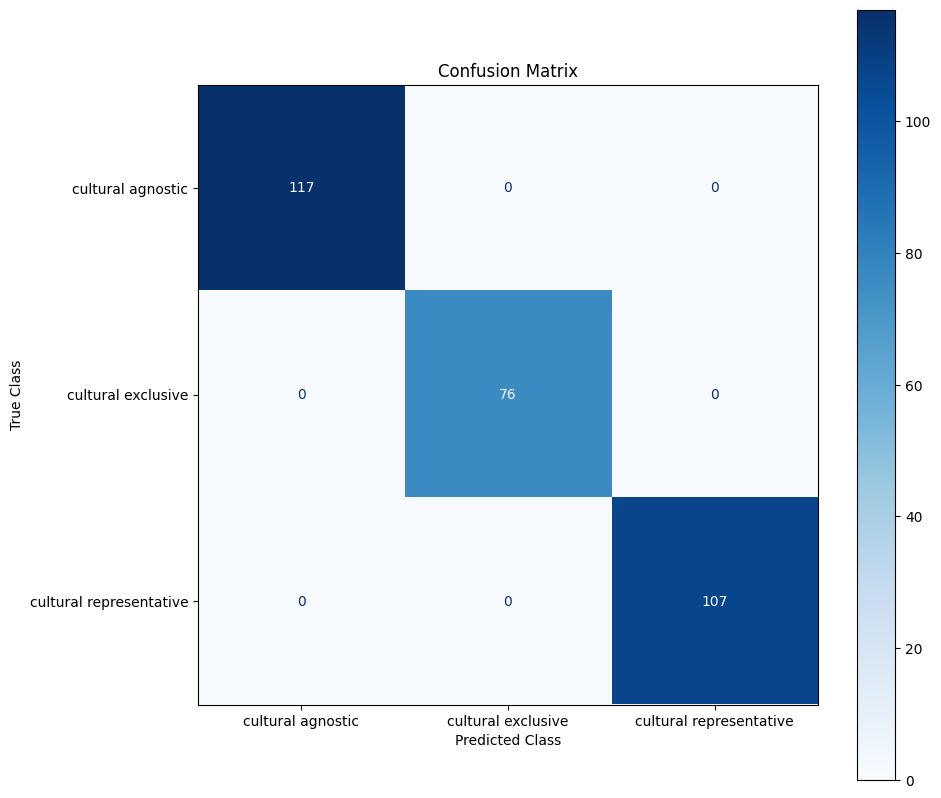

In [136]:
all_preds = []
all_targets = y_test_encoded # Use the numerical encoded labels

transformer.eval()
transformer.to('cpu')

with torch.no_grad():
    for src_text in X_test:
        predicted_class_index = predict_class(transformer, src_text, input_vocabulary, max_seq_length, 'cpu')
        all_preds.append(predicted_class_index)

class_names = label_encoder.classes_ # Get the original class names

plt.figure(figsize=(10, 10))

cm = confusion_matrix(all_targets, all_preds, labels=range(num_classes))
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot(ax=plt.gca(), cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()